In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import time
import seaborn as sns

In [3]:
class GridWorld:
    def __init__(self, size=100, obstacle_density=0.3):
        self.size = size
        self.grid = np.zeros((size, size))
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        self.generate_environment(obstacle_density)

    def generate_environment(self, obstacle_density):
        # Generate random obstacles
        self.grid = np.random.choice([0, 1], size=(self.size, self.size),
                                   p=[1-obstacle_density, obstacle_density])

        # Generate start and goal states
        while True:
            self.start = (random.randint(0, self.size-1), random.randint(0, self.size-1))
            self.goal = (random.randint(0, self.size-1), random.randint(0, self.size-1))

            if (self.grid[self.start] == 0 and self.grid[self.goal] == 0 and
                self.start != self.goal):
                break

        self.grid[self.start] = 2  # Start state
        self.grid[self.goal] = 3   # Goal state

    def is_valid_state(self, state):
        x, y = state
        return (0 <= x < self.size and 0 <= y < self.size and
                self.grid[x, y] != 1)

    def get_next_state(self, state, action):
        next_state = (state[0] + action[0], state[1] + action[1])
        if not self.is_valid_state(next_state):
            return state
        return next_state

    def get_reward(self, state):
        if state == self.goal:
            return 100
        elif not self.is_valid_state(state):
            return -100
        return -1

In [4]:
class ValueIteration:
    def __init__(self, env, gamma=0.99, theta=1e-6):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.V = defaultdict(float)
        self.policy = {}

    def solve(self, max_iterations=1000):
        iteration = 0
        while iteration < max_iterations:
            delta = 0
            for i in range(self.env.size):
                for j in range(self.env.size):
                    if self.env.grid[i, j] == 1:  # Skip obstacles
                        continue

                    state = (i, j)
                    if state == self.env.goal:
                        continue

                    v = self.V[state]
                    max_v = float('-inf')
                    best_action = None

                    for action in self.env.actions:
                        next_state = self.env.get_next_state(state, action)
                        reward = self.env.get_reward(next_state)
                        v_next = reward + self.gamma * self.V[next_state]

                        if v_next > max_v:
                            max_v = v_next
                            best_action = action

                    self.V[state] = max_v
                    self.policy[state] = best_action
                    delta = max(delta, abs(v - self.V[state]))

            if delta < self.theta:
                break
            iteration += 1

        return self.V, self.policy, iteration


In [5]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: defaultdict(float))

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)
        return max(self.env.actions, key=lambda a: self.Q[state][a])

    def solve(self, episodes=1000):
        total_rewards = []

        for episode in range(episodes):
            state = self.env.start
            total_reward = 0

            while state != self.env.goal:
                action = self.get_action(state)
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)

                # Q-learning update
                best_next_value = max(self.Q[next_state].values()) if self.Q[next_state] else 0
                self.Q[state][action] += self.alpha * (reward + self.gamma * best_next_value -
                                                     self.Q[state][action])

                state = next_state
                total_reward += reward

                if not self.env.is_valid_state(state):
                    break

            total_rewards.append(total_reward)

        return self.Q, total_rewards

In [6]:
def benchmark_algorithms(grid_size=100, num_runs=5):
    results = {
        'Value Iteration': {'time': [], 'iterations': []},
        'Q-Learning': {'time': [], 'rewards': []}
    }

    for _ in range(num_runs):
        env = GridWorld(size=grid_size)

        # Value Iteration
        start_time = time.time()
        vi = ValueIteration(env)
        _, _, iterations = vi.solve()
        vi_time = time.time() - start_time
        results['Value Iteration']['time'].append(vi_time)
        results['Value Iteration']['iterations'].append(iterations)

        # Q-Learning
        start_time = time.time()
        ql = QLearning(env)
        _, rewards = ql.solve()
        ql_time = time.time() - start_time
        results['Q-Learning']['time'].append(ql_time)
        results['Q-Learning']['rewards'].append(np.mean(rewards))

    return results


In [7]:
def visualize_results(results):
    plt.figure(figsize=(12, 5))

    # Execution Time Comparison
    plt.subplot(121)
    algorithms = list(results.keys())
    times = [np.mean(results[alg]['time']) for alg in algorithms]
    plt.bar(algorithms, times)
    plt.title('Average Execution Time')
    plt.ylabel('Time (seconds)')

    # Q-Learning Rewards
    plt.subplot(122)
    rewards = np.mean(results['Q-Learning']['rewards'])
    iterations = np.mean(results['Value Iteration']['iterations'])
    plt.bar(['Q-Learning Rewards', 'VI Iterations'], [rewards, iterations])
    plt.title('Performance Metrics')

    plt.tight_layout()
    return plt


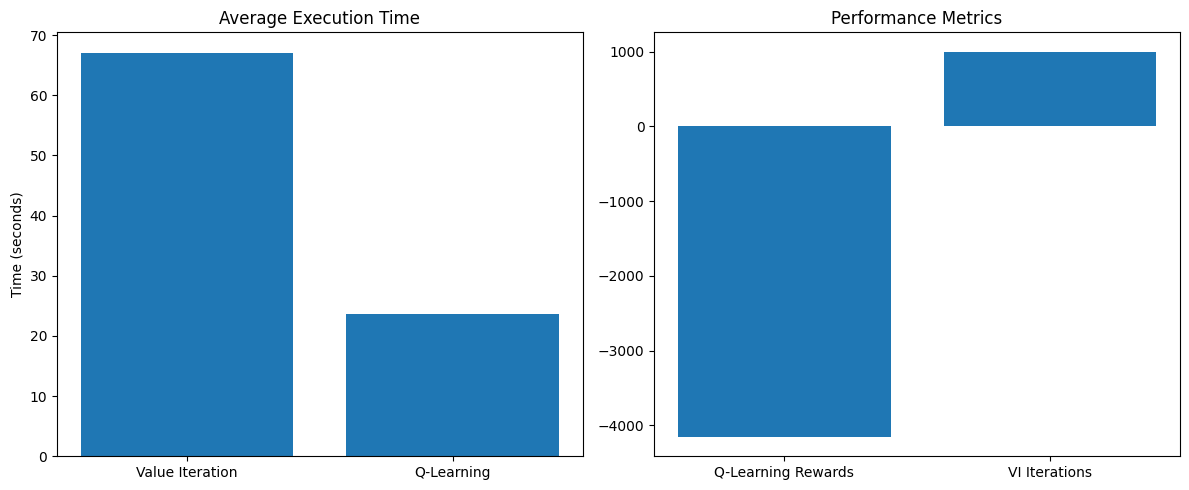

In [8]:
env = GridWorld(size=100)
results = benchmark_algorithms()
plt = visualize_results(results)
plt.show()

In [9]:
print(results)

{'Value Iteration': {'time': [67.19325947761536, 66.15342783927917, 66.98392939567566, 69.19077682495117, 65.9799575805664], 'iterations': [1000, 1000, 1000, 1000, 1000]}, 'Q-Learning': {'time': [12.061792373657227, 13.096393346786499, 36.33236479759216, 35.56331753730774, 21.341145992279053], 'rewards': [-2122.301, -2323.412, -6277.846, -6326.759, -3729.488]}}
